## 2023 CVE CNA Data Review 

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2023}.json.zip 
!unzip -o "*.zip" 
!wget https://raw.githubusercontent.com/CVEProject/cve-website/dev/src/assets/data/CNAsList.json

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import calplot
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('Rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2023-01-01') & (nvd['Published']  < '2024-01-01'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2023, 1, 1)
enddate  = date(2024, 1, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

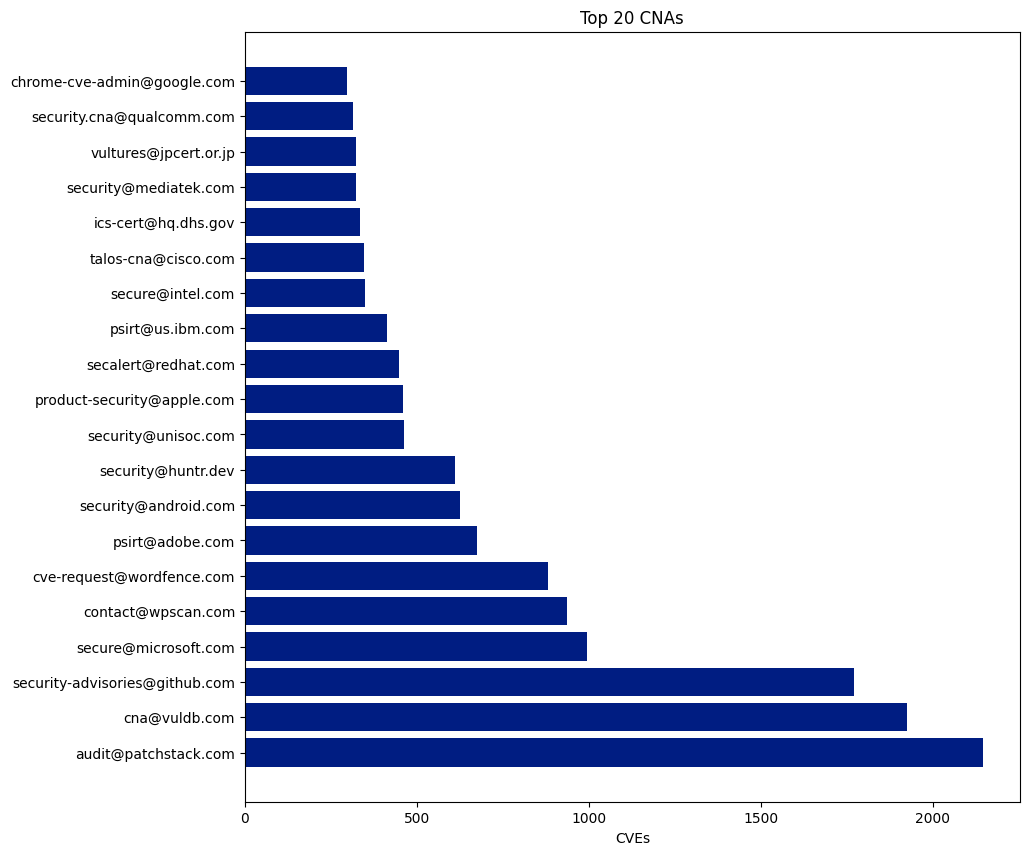

In [13]:
nvd_frequency = nvd['Assigner'].value_counts()
nvd_frequency = nvd_frequency.reset_index()
nvd_frequency.columns = ['Assigner', 'Count']
nvd_frequency['Percentage'] = ( nvd_frequency['Count'] / 
                       nvd_frequency['Count'].sum()) * 100

nvd_frequency_no_mitre = nvd_frequency[~nvd_frequency.Assigner.str.contains('cve@mitre.org')]
nvd_frequency_no_mitre = nvd_frequency_no_mitre[nvd_frequency_no_mitre.Count > 100].head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "Count", data = nvd_frequency_no_mitre, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");

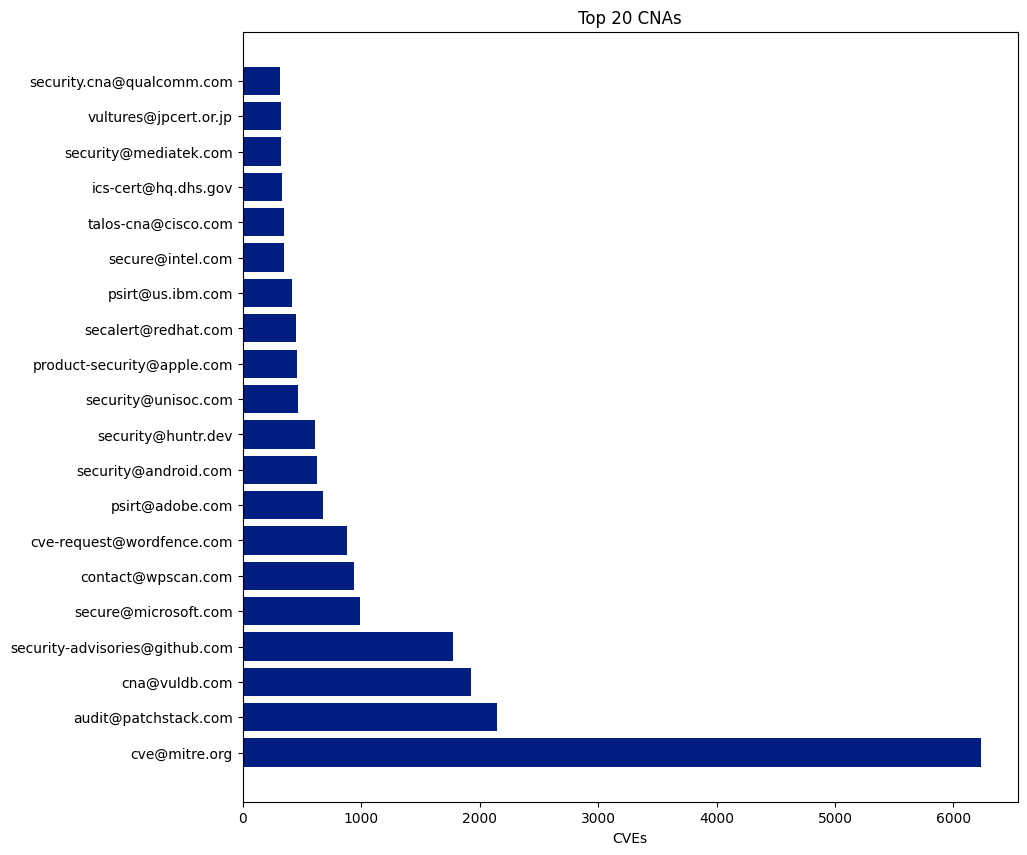

In [14]:
nvd_frequency_graph = nvd_frequency[nvd_frequency.Count > 100].head(20)
plt.figure(figsize=(10,10))
plt.barh("Assigner", "Count", data = nvd_frequency_graph, color="#001d82")
plt.xlabel("CVEs"); 
plt.ylabel("") ;
plt.title("Top 20 CNAs");

In [15]:
nvd_frequency.round(2)

,Assigner,Count,Percentage
0,cve@mitre.org,6231,21.56
1,audit@patchstack.com,2146,7.43
2,cna@vuldb.com,1925,6.66
3,security-advisories@github.com,1771,6.13
4,secure@microsoft.com,994,3.44
...,...,...,...
245,security@illumio.com,1,0.00
246,vulseclabs@example.com,1,0.00
247,security@mimsoftware.com,1,0.00
248,info@greenrocketsecurity.com,1,0.00


In [16]:

from pandas.io.json import json_normalize #package for flattening json in pandas df

with open('CNAsList.json') as f:
    data = json.load(f)

cna_emails = json_normalize(data=data, record_path=['contact', 'email'])
all_cna_emails = cna_emails['emailAddr'].to_list()
published_cna_emails = nvd_frequency['Assigner'].to_list()


## Not Published

In [17]:
not_pulished = list(set(all_cna_emails).symmetric_difference(set(published_cna_emails)))
not_pulished = pd.DataFrame(not_pulished)
not_pulished

,0
0,
1,tektagonsecurity@ami.com
2,psirt@synopsys.com
3,secure@arcinfo.com
4,securityresponse@absolute.com
...,...
151,security@suse.de
152,securities@openeuler.org
153,security@google.com
154,cna@manageengine.com


## Not Listed

In [18]:
s = set(published_cna_emails)
not_used = [x for x in all_cna_emails if x not in s]
not_used = pd.DataFrame(not_used)
not_used.reset_index()
not_used.rename(columns={0:'Email Address'}, inplace=True)
not_used


,Email Address
0,vuln@airbus.com
1,cve@aliasrobotics.com
2,alibaba-cna@list.alibaba-inc.com
3,psirt@amperecomputing.com
4,android-cna-team@google.com
...,...
115,cna@manageengine.com
116,security.reports@fortra.com
117,disclosures@enterprisedb.com
118,disclosure@hiddenlayer.com


In [19]:

s = set(all_cna_emails)
not_listed_list = [x for x in published_cna_emails if x not in s]
not_listed = pd.DataFrame(not_listed_list)
not_listed.reset_index()
not_listed.rename(columns={0:'Email Address'}, inplace=True)
not_listed_count = nvd_frequency[nvd_frequency['Assigner'].isin(not_listed_list)]
not_listed_count = not_listed_count.round(2)
not_listed_count

,Assigner,Count,Percentage
0,cve@mitre.org,6231,21.56
8,security@android.com,625,2.16
9,security@huntr.dev,612,2.12
16,ics-cert@hq.dhs.gov,335,1.16
18,vultures@jpcert.or.jp,324,1.12
19,security.cna@qualcomm.com,314,1.09
32,psirt@fortinet.com,198,0.69
38,support@hackerone.com,144,0.50
45,cybersecurity@schneider-electric.com,94,0.33
51,patrick@puiterwijk.org,65,0.22
